#**Klasifikasi Dataset Capstone Project**


Setelah proses clustering dilakukan untuk mengelompokkan data tanpa label, tahap selanjutnya adalah membangun model klasifikasi untuk memprediksi cluster dari data baru (pengguna) berdasarkan pola fitur yang telah terbentuk. Pada tahap ini digunakan algoritma **Artificial Neural Network (ANN)** sebagai model klasifikasi karena kemampuannya dalam menangkap hubungan kompleks antar fitur.

Dataset yang digunakan adalah dataset hasil clustering `Dataset_final_input_user.csv` yang berjumlah 20.000 data. Dari total 20.000 data yang tersedia, sebanyak **15.000 data digunakan untuk proses pelatihan** dan validasi model klasifikasi, sedangkan 5.000 data sisanya disimpan secara terpisah untuk tahap pengujian akhir.

Proses ini bertujuan untuk membangun model prediktif yang dapat mengklasifikasikan data ke dalam cluster yang telah ditentukan sebelumnya, meskipun data tersebut belum pernah dilihat oleh model.


# **1. Data Understanding**

## Package/Library yang digunakan

Pada tahapan pertama dari proses clustering akan dilakukan import package/library yang diperlukan untuk kemudahan dalam proses analisis data, eksplorasi, pemodelan deep learning, visualisasi, serta evaluasi hasil

Beberapa library utama telah dijelaskan pada notebook sebelumnya, sehingga pada bagian ini hanya dijelaskan library tambahan yang belum dibahas sebelumnya, yaitu:

*   `!pip install keras-tuner --upgrade`
    > Untuk menginstal/memperbarui library keras-tuner ke versi terbaru. keras-tuner adalah library tambahan untuk Keras yang digunakan dalam proses hyperparameter tuning, yakni untuk pencarian kombinasi parameter model terbaik (seperti jumlah neuron, learning rate, batch size, dll) secara otomatis untuk meningkatkan performa model

*   `!pip install imbalanced-learn`
    > Untuk menangani dataset yang tidak seimbang (imbalanced) dalam konteks klasifikasi, terdapat berbagai teknik seperti oversampling (SMOTE) dan undersampling, yang berguna untuk memperbaiki distribusi kelas agar model klasifikasi tidak bias terhadap kelas mayoritas dan dapat menghasilkan prediksi yang lebih akurat serta adil.

*   `from sklearn.model_selection import StratifiedKFold, train_test_split`
    > Untuk membagi dataset dan melakukan validasi model. `train_test_split` digunakan untuk membagi data menjadi data latih dan data uji, sedangkan `StratifiedKFold` adalah teknik validasi silang (cross-validation) yang memastikan distribusi label seimbang di setiap lipatan (fold), sangat penting untuk data klasifikasi yang tidak seimbang.

*   `from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler,FunctionTransformer`
    > Untuk transformasi data agar lebih sesuai untuk proses training model. `StandardScaler` dan `MinMaxScaler` digunakan untuk melakukan normalisasi atau standarisasi data numerik, `LabelEncoder` digunakan untuk mengubah label kategorikal menjadi numerik, dan `FunctionTransformer` untuk menerapkan fungsi kustom dalam pipeline preprocessing.

*   `from sklearn.pipeline import Pipeline`
    > Untuk menyusun urutan preprocessing dan training model dalam satu objek yang terintegrasi, mempermudah proses eksperimen dan memastikan semua tahapan preprocessing konsisten selama pelatihan dan pengujian.

*   `from sklearn.utils import class_weight`
    > Untuk fungsi utilitas tambahan. `class_weight` digunakan untuk menangani ketidakseimbangan kelas dalam model klasifikasi dengan memberi bobot lebih besar pada kelas minoritas saat training model.

*   `from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix`
    > Untuk metrik evaluasi model. `accuracy_score` dan `f1_score` digunakan untuk menilai kinerja model klasifikasi, sedangkan `classification_report` dan `confusion_matrix` digunakan untuk memberikan gambaran detail terhadap prediksi model dibanding label aktual, termasuk precision, recall, dan f1-score per kelas.

*   `from imblearn.over_sampling import SMOTE`
    > Untuk menangani dataset tidak seimbang. SMOTE (Synthetic Minority Over-sampling Technique) adalah teknik yang membuat data sintetis untuk kelas minoritas agar distribusi kelas menjadi lebih seimbang dan model tidak bias terhadap kelas mayoritas.

*   `tensorflow`
    > Untuk membangun dan melatih model deep learning. `Sequential` digunakan untuk membangun model ANN secara berlapis. `Dense`, `Dropout`, `BatchNormalization`, dan `LeakyReLU` adalah komponen lapisan dalam jaringan saraf, sedangkan `categorical_crossentropy` digunakan sebagai fungsi loss untuk klasifikasi multi-kelas, `callbacks` seperti `EarlyStopping` dan `ReduceLROnPlateau` digunakan untuk membantu mengoptimalkan proses training, `to_categorical` mengubah label menjadi bentuk one-hot encoding, dan l2 digunakan sebagai regularisasi untuk mengurangi overfitting.

*   `import keras_tuner as kt`
    > Untuk melakukan tuning hyperparameter secara otomatis pada model Keras. Digunakan untuk mencari kombinasi parameter terbaik seperti jumlah neuron, learning rate, atau batch size untuk meningkatkan performa model secara sistematis.

*   `import pickle`
    > Untuk menyimpan model, pickle digunakan untuk berbagai jenis objek Python.

*   `import joblib`
    > Untuk menyimpan model, joblib digunakan untuk objek besar.

*   `import warnings`

     `warnings.filterwarnings('ignore')`
    >  Untuk menyembunyikan peringatan agar output notebook tetap bersih dan fokus pada hasil utama.


In [4]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.2 MB/s eta 0:00:00


In [5]:
!pip install imbalanced-learn

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler,FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

import keras_tuner as kt
import pickle
import joblib

import warnings
warnings.filterwarnings('ignore')

## Data Loading

In [7]:
file_id = '1XRPFF_MUxeXYBQKT86Qp3a_Orje0K95f'
url = f'https://drive.google.com/uc?export=download&id={file_id}'

df = pd.read_csv(url)
df.head()

,Unnamed: 0,Pendapatan Bulanan,Total Pengeluaran,Tabungan,Cicilan Per Bulan,Dana Darurat,Total Aset,Total Utang,Target
0,0,3624413,3139614,197938,735441,282643,13500000,36036636,0
1,1,6288582,5605819,1175000,339530,280751,9000000,2376712,1
2,2,7056362,5504003,1407490,926730,708530,3000000,19461335,0
3,3,1947890,1612226,453842,271957,163494,3000000,12510042,0
4,5,2190254,2029233,251592,598245,159353,10500000,9571926,0


## Pembuatan Pipeline

Tahapan selanjutnya adalah membangun pipeline untuk menggabungkan beberapa tahapan preprocessing sebelum dataset masuk ke dalam model ANN

### Drop Fitur Unname

In [8]:
df_clean = df.drop('Unnamed: 0',axis=1)

Tahap pertama dari pembuatan pipeline adalah melakukan **drop fitur** `Unnamed`, karena fitur ini tidak memiliki informasi penting yang dapat digunakan. Kemudian dataset yang telah dilakukan drop pada fitur `Unnamed` disimpan dalam `df_clean`

### Split Dataset

Tahapan selanjutnya adalah **split dataset** dilakukan dengan 1.000 data terakhir dari `df_clean` sebagai data testing eksternal, yang nantinya akan digunakan untuk menguji model terbaik setelah training dan evaluasi awal selesai. Data ini disimpan dalam `df_testing.csv` dan tidak digunakan pada training.

Kemudian `df_training` digunakan untuk training dan validasi model.

In [9]:
df_testing = df_clean.tail(1000)
df_testing.to_csv('data_testing.csv')

In [10]:
df_training = df_clean.iloc[:-1000]
df_training

,Pendapatan Bulanan,Total Pengeluaran,Tabungan,Cicilan Per Bulan,Dana Darurat,Total Aset,Total Utang,Target
0,3624413,3139614,197938,735441,282643,13500000,36036636,0
1,6288582,5605819,1175000,339530,280751,9000000,2376712,1
2,7056362,5504003,1407490,926730,708530,3000000,19461335,0
3,1947890,1612226,453842,271957,163494,3000000,12510042,0
4,2190254,2029233,251592,598245,159353,10500000,9571926,0
...,...,...,...,...,...,...,...,...
15090,6465316,5769611,593128,378691,426871,3000000,8709898,0
15091,4921722,4394099,457637,1182782,287165,12000000,16558960,0
15092,2443037,2785063,462131,375702,339875,4500000,18033721,0
15093,4847939,3882748,699695,1417961,637988,6000000,56718467,0


### Pembuatan Fungsi Untuk Pipeline Ratio

Langkah ini merupakan pembuatan fungsi untuk menghitung rasio keuangan dan penerapannya dalam pipeline preprocessing untuk menghasilkan fitur rasio finansial, lalu menormalkannya agar siap digunakan dalam model klasifikasi

In [11]:
def compute_ratio(col):
    epsilon = 1e-6
    pendapatan_bulanan = col[:,0]
    total_pengeluaran = col[:,1]
    tabungan = col[:,2]
    cicilan_perbulan = col[:,3]
    dana_darurat = col[:,4]
    total_aset = col[:,5]
    total_utang = col[:,6]

    ExpenseToIncomeRatio = total_pengeluaran / (pendapatan_bulanan + epsilon)
    SavingToIncomeRatio = tabungan / (pendapatan_bulanan + epsilon)
    DebtToIncomeRatio = cicilan_perbulan / (pendapatan_bulanan + epsilon)
    EmergencyFundRatio = dana_darurat / (total_pengeluaran + epsilon)
    AssetToDebtRatio = total_aset / (total_utang + epsilon)
    DebtToAssetRatio = total_utang / (total_aset + epsilon)

    return np.stack([
        ExpenseToIncomeRatio,
        SavingToIncomeRatio,
        DebtToIncomeRatio,
        EmergencyFundRatio,
        AssetToDebtRatio,
        DebtToAssetRatio
    ], axis=1)


preprocessing_pipeline = Pipeline([
    ("ratio_calc", FunctionTransformer(compute_ratio)),
    ("scaler", MinMaxScaler())
])



## Exploratory Data Analysis (EDA)

Tahapan selanjutnya adalah exploratory Data Analysis (EDA) untuk memahami struktur, pola, dan karakteristik data sebelum dilakukan pemodelan atau analisis lebih lanjut.

### Barplot untuk melihat distribusi masing-masing kelas

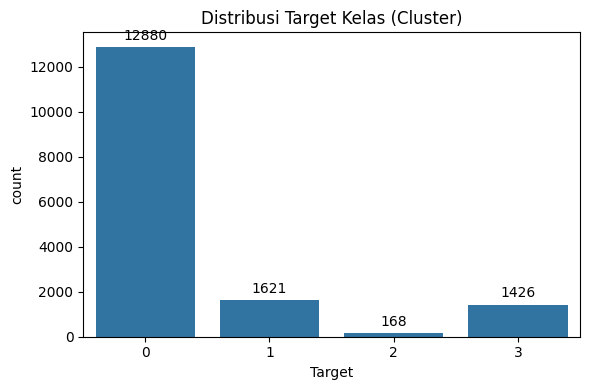

In [12]:
plt.figure(figsize=(6,4))
ax = sns.countplot(x='Target', data=df_clean)
plt.title("Distribusi Target Kelas (Cluster)")

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.tight_layout()
plt.show()

# **2. Data Preparation**

**Insight**

Dapat dilihat bahwa persebaran data tidak seimbang (imbalanced) dengan data pada kelas 0 merupakan kelas dengan data terbanyak yakni sebanyak  12880 data dan data pada kelas 2 merupakan kelas dengan data tersedikit yakni hanya sebnayak 168 data.

Ketidakseimbangan dapat menimbulkan biar pada model klasifikasi. Sehingga perlu dilakukan penanganan

Tahapan selanjutnya adalah data preparation, yakni proses menyiapkan dataset agar siap digunakan untuk analisis dan pemodelan.

Berdasarkan hasil EDA diketahui bahwa dataset yang digunakan terjadi imbalance sehingga akan dilakukan penanganan

### Pemisahan Data Fitur Dan Target

Tahapan pertama dari data preprocessing adalah mengambil fitur-fitur numerik utama dari dataset `df` dan menyimapnanya sebagai array NumPy kemudian disimpan dalam `X_raw`

Menyimpan label atau traget klasfikasi dalam `y`

In [13]:
X_raw = df[[
    'Pendapatan Bulanan', 'Total Pengeluaran', 'Tabungan',
    'Cicilan Per Bulan', 'Dana Darurat', 'Total Aset', 'Total Utang']].values
y = df['Target'].values

### Transformasi Fitur

Tahapan akhir dari data preprocessing yakni melakukan transormasi data dengan menghitung rasio-rasio finansial yang telah didefinisikan sebelumnya, dan menormalisasi hasilnya.

In [14]:
preprocessing_pipeline = Pipeline([
    ("ratio_calc", FunctionTransformer(compute_ratio)),
    ("scaler", MinMaxScaler())
])

# **3. Klasifikasi**

### Modeling

**Model Artificial Neural Network (ANN) untuk klasifikasi multi-jelas.**

Pada tahapan ini akan dibangun model ANN secara berurutan (Sequential) dimulai dari layer `input`, `dense layer` dan `aktivasi ReLU`, kemudian digunakan `batch normalization` untuk menstabilkan pembelajaran, serta `dropout` untuk mencegah overfitting. Layer output menggunakan aktivasi softmax agar dapat menghasilkan probabilitas untuk masing-masing kelas. Model dikompilasi dengan optimizer `Adam`, fungsi loss `categorical_crossentropy` (karena klasifikasinya multi-kelas)

In [15]:
def build_model(input_dim, output_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

### Training K-Fold

Tahapan selanjutnya setelah membuat model ANN adalah melatih model klasifikasi ANN menggunakan teknik validasi silang Stratified K-Fold sebanyak 5 fold.

Tujuannya adalah mengevaluasi performa model secara menyeluruh dengan membagi data menjadi beberapa subset agar tiap kelas tetap seimbang di setiap fold.

Pada setiap iterasi, data dilatih dan divalidasi menggunakan pipeline preprocessing, model dibangun dan dilatih, lalu dievaluasi dengan metrik akurasi dan f1-score.

Output dari proses ini berupa daftar hasil performa tiap fold (fold_results), model terbaik dari tiap fold (best_models), dan riwayat pelatihan (all_histories), serta visualisasi confusion matrix dan classification report per fold.


=== Fold 1 ===
Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.3733 - loss: 1.4571 - val_accuracy: 0.8034 - val_loss: 0.9853 - learning_rate: 0.0010
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7609 - loss: 0.7569 - val_accuracy: 0.8018 - val_loss: 0.7001 - learning_rate: 0.0010
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8825 - loss: 0.4303 - val_accuracy: 0.8018 - val_loss: 0.5772 - learning_rate: 0.0010
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9108 - loss: 0.3006 - val_accuracy: 0.8058 - val_loss: 0.5251 - learning_rate: 0.0010
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9312 - loss: 0.2229 - val_accuracy: 0.8130 - val_loss: 0.4770 - learning_rate: 0.0010
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9451 - loss: 0.1793 - val_accuracy: 0.8245 - val_loss: 0.4176 - learning_rate: 0.0010
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9492 - loss: 0.1541

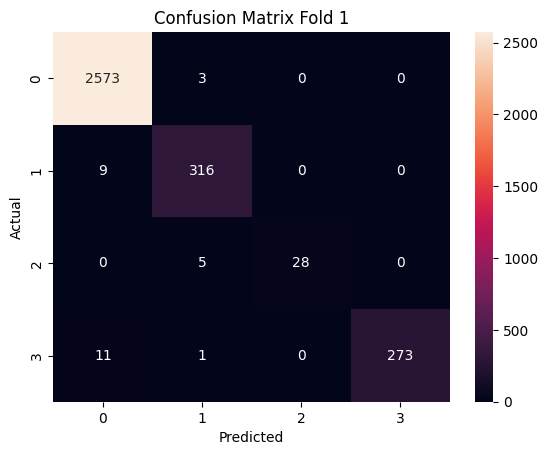


=== Fold 2 ===
Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.4164 - loss: 1.3220 - val_accuracy: 0.8009 - val_loss: 0.9814 - learning_rate: 0.0010
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7663 - loss: 0.7359 - val_accuracy: 0.8002 - val_loss: 0.6922 - learning_rate: 0.0010
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8941 - loss: 0.4072 - val_accuracy: 0.8002 - val_loss: 0.5813 - learning_rate: 0.0010
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9229 - loss: 0.2722 - val_accuracy: 0.8009 - val_loss: 0.5357 - learning_rate: 0.0010
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9382 - loss: 0.2083 - val_accuracy: 0.8052 - val_loss: 0.4887 - learning_rate: 0.0010
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9449 - loss: 0.1756 - val_accuracy: 0.8201 - val_loss: 0.4291 - learning_rate: 0.0010
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9505 - loss: 0.1537

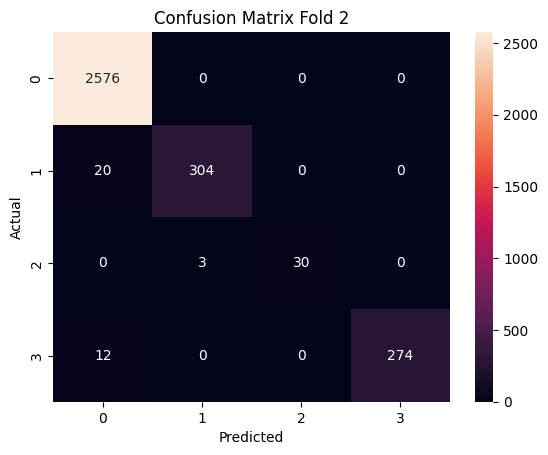


=== Fold 3 ===
Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.3634 - loss: 1.4560 - val_accuracy: 0.8099 - val_loss: 1.0368 - learning_rate: 0.0010
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7538 - loss: 0.7824 - val_accuracy: 0.8040 - val_loss: 0.7345 - learning_rate: 0.0010
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8846 - loss: 0.4479 - val_accuracy: 0.8040 - val_loss: 0.5823 - learning_rate: 0.0010
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9228 - loss: 0.2888 - val_accuracy: 0.8068 - val_loss: 0.5259 - learning_rate: 0.0010
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9346 - loss: 0.2238 - val_accuracy: 0.8127 - val_loss: 0.4795 - learning_rate: 0.0010
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9408 - loss: 0.1830 - val_accuracy: 0.8260 - val_loss: 0.4277 - learning_rate: 0.0010
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9518 - loss: 0.1539

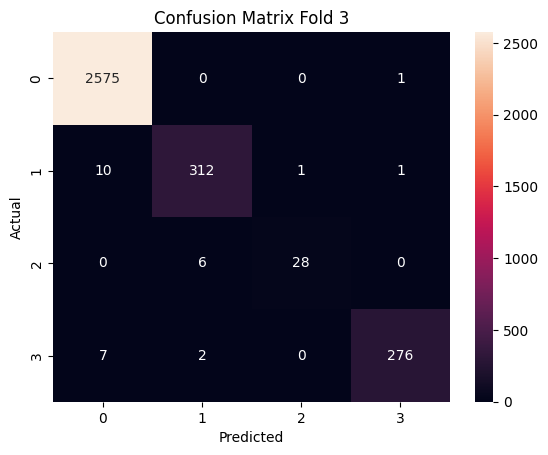


=== Fold 4 ===
Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.4091 - loss: 1.4527 - val_accuracy: 0.8002 - val_loss: 0.9835 - learning_rate: 0.0010
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7826 - loss: 0.7303 - val_accuracy: 0.8002 - val_loss: 0.7014 - learning_rate: 0.0010
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8904 - loss: 0.4145 - val_accuracy: 0.8006 - val_loss: 0.5976 - learning_rate: 0.0010
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9073 - loss: 0.2925 - val_accuracy: 0.8021 - val_loss: 0.5531 - learning_rate: 0.0010
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9260 - loss: 0.2271 - val_accuracy: 0.8058 - val_loss: 0.5136 - learning_rate: 0.0010
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9422 - loss: 0.1803 - val_accuracy: 0.8145 - val_loss: 0.4560 - learning_rate: 0.0010
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9392 - loss: 0.1668

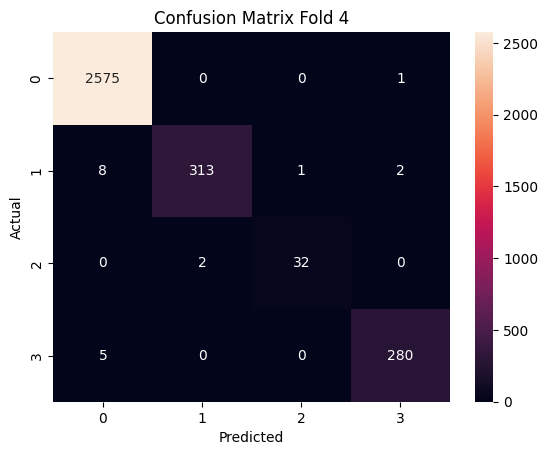


=== Fold 5 ===
Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.4044 - loss: 1.4378 - val_accuracy: 0.8002 - val_loss: 0.9621 - learning_rate: 0.0010
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7857 - loss: 0.7295 - val_accuracy: 0.8006 - val_loss: 0.6882 - learning_rate: 0.0010
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9050 - loss: 0.3967 - val_accuracy: 0.8002 - val_loss: 0.5975 - learning_rate: 0.0010
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9309 - loss: 0.2605 - val_accuracy: 0.8009 - val_loss: 0.5639 - learning_rate: 0.0010
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9383 - loss: 0.2079 - val_accuracy: 0.8027 - val_loss: 0.5278 - learning_rate: 0.0010
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9420 - loss: 0.1787 - val_accuracy: 0.8133 - val_loss: 0.4776 - learning_rate: 0.0010
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9521 - loss: 0.1492

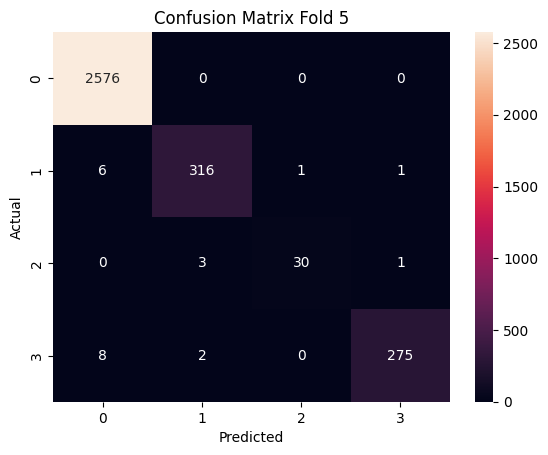

In [16]:
le = LabelEncoder()
y_int = le.fit_transform(y)

fold_results = []
best_models = []
all_histories = []

fold_no = 1

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in skf.split(X_raw, y_int):
    print(f"\n=== Fold {fold_no} ===")

    X_train_df, X_val_df = X_raw[train_idx], X_raw[val_idx]
    y_train_int, y_val_int = y_int[train_idx], y_int[val_idx]

    X_train_processed = preprocessing_pipeline.fit_transform(X_train_df)
    X_val_processed = preprocessing_pipeline.transform(X_val_df)

    model = build_model(X_train_processed.shape[1], len(le.classes_))

    y_train_one_hot = to_categorical(y_train_int, num_classes=len(le.classes_))
    y_val_one_hot = to_categorical(y_val_int, num_classes=len(le.classes_))


    history = model.fit(
        X_train_processed, y_train_one_hot,
        epochs=30,
        batch_size=256,
        validation_data=(X_val_processed, y_val_one_hot),

        callbacks=[
            EarlyStopping(patience=3, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
        ],
        verbose=1
    )

    all_histories.append(history)

    y_pred = model.predict(X_val_processed)
    y_pred_classes = np.argmax(y_pred, axis=1)

    best_models.append(model)

    print("Classification Report:")
    target_names_str = [str(cls) for cls in le.classes_]
    print(classification_report(y_val_int, y_pred_classes, target_names=target_names_str))

    print("Confusion Matrix:")
    sns.heatmap(confusion_matrix(y_val_int, y_pred_classes), annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix Fold {fold_no}')
    plt.show()

    acc = accuracy_score(y_val_int, y_pred_classes)
    f1 = f1_score(y_val_int, y_pred_classes, average='weighted')
    fold_results.append({
        'fold': fold_no,
        'accuracy': acc,
        'f1_score': f1
    })

    fold_no += 1

### Evaluasi Model

Tahapan selanjutnya setelah dilakukan modeling, tahapan selanjutnya adalah melakukaan evaluasi model ANN.

Dilakukan analisis performa model dari seluurh fold pada proses K-Fold sebelumnya. Hasil akurasi dan f1-score dari setiap fold disimpan dalam `result_df` untuk ditampilkan.

Fold dengan performa terbaik (berdasarkan f1-score tertinggi) akan ditampilkan informasinya. Kemudian, visualisasi akurasi dan loss dari fold terbaik tersebut ditampilkan untuk memahami dinamika pelatihan model


=== Ringkasan Hasil per Fold ===
   fold  accuracy  f1_score
0     1  0.990991  0.990899
1     2  0.989127  0.988999
2     3  0.991302  0.991183
3     4  0.994098  0.994063
4     5  0.993166  0.993100

Fold terbaik: Fold 4.0 dengan F1-score: 0.9941


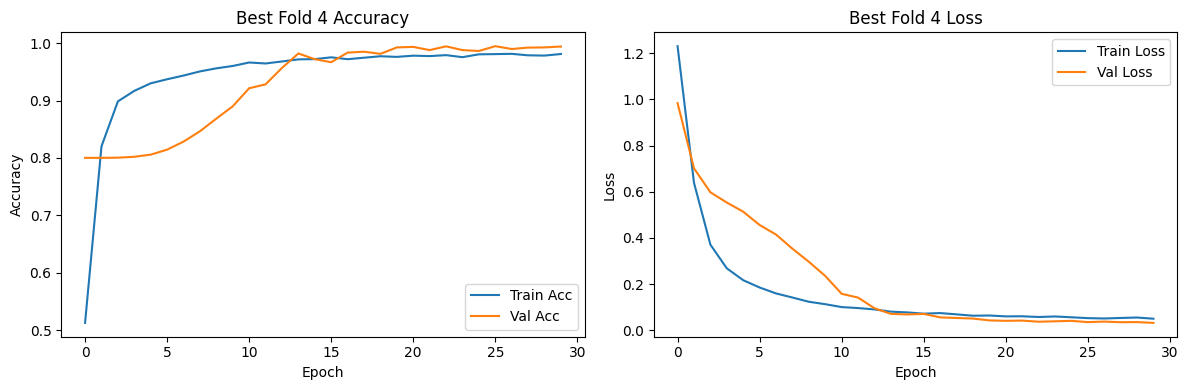

In [17]:
results_df = pd.DataFrame(fold_results)
print("\n=== Ringkasan Hasil per Fold ===")
print(results_df)

best_idx = results_df['f1_score'].idxmax()
best_fold = results_df.loc[best_idx]
print(f"\nFold terbaik: Fold {best_fold['fold']} dengan F1-score: {best_fold['f1_score']:.4f}")

best_history = all_histories[best_idx]

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(best_history.history['accuracy'], label='Train Acc')
plt.plot(best_history.history['val_accuracy'], label='Val Acc')
plt.title(f'Best Fold {int(best_fold["fold"])} Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Val Loss')
plt.title(f'Best Fold {int(best_fold["fold"])} Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Insight**

Diperoleh fold terbaik yakni pada fold ke-1 dengan F1-score sebesar 0.9934. Berdasarkan grafik akurasi dan loss dari fold terbaik (fold ke-1) diperoleh bahwa model belajar dengan baik tanpa overfitting karena terlihat bahwa akurasi pada data pelatihan dan validasi meningkat seiring bertambahnya epoch, lalu mendatar mendekati konvergensi dan loss menurun drastis di awal pelatihan dan stabil di nilai rendah

# **4. Convert Model**

Setelah membangun model ANN terbaik berhasil dilatih, tahapan terakhir yakni menyimpan model beserta pipeline preprocessing untuk memudahkan deployment. Model disimpan dalam format `.keras` yang berisikan arsitektur dan bobot dalam satu file.

Pipeline preprocessing juga disimpan dalam format `.pkl` menggunakan `joblib`, sehingga data baru dapat diproses dengan cara yang sama seperti saat pelatihan. Penyimpanan ini penting agar model dapat dimuat kembali tanpa perlu pelatihan ulang, baik untuk evaluasi lanjutan maupun integrasi ke sistem produksi.

In [18]:
model.save("model_sakoo_ann.keras")
print("Model Keras disimpan di 'model_sakoo_ann.keras'")

joblib.dump(preprocessing_pipeline, "preprocessing.pkl")


Model Keras disimpan di 'model_sakoo_ann.keras'


['preprocessing.pkl']